</a><a name='top'>
# Combining snowfall detection procedure and snow compaction/temperature models

This notebook uses and combines the preliminary work done previously to see if models and procedures developed so far are consistent with observations.

We detect snow accumulation and erosion events, build layers accordingly, simulate their evolution and plot our results against the snow-depth curve obtained from the lidar.
    
This notebook is organized so that only one set of parameters should be modified (see link below), before simply running the whole notebook from the start.

[Define parameters in this section](#params)

### Imports and functions

In [1]:
%run little_awk_functions.py


### Define data

In [2]:
# Get data from files

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/20*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')

# all_data = xr.open_mfdataset('/home/mabonnet/Desktop/data/2021_2022_livox_surfaces/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# all_data.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_2021-2022.nc')
all_data_set = xr.open_dataset('data_2021-2022.nc')

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/data-filled/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(84,106), y=slice(28,50)).to_netcdf('snow_pit_1_filled.nc')
data_pit_1 = xr.open_dataset('snow_pit_1.nc')

# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/data-filled/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(105,127), y=slice(39,61)).to_netcdf('snow_pit_2_filled.nc')
data_pit_2 = xr.open_dataset('snow_pit_2.nc')

# data_dec_jan_fev_filled = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/data-filled/*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev_filled.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_filled_pit.nc')
data_dec_jan_feb_filled = xr.open_dataset('data_dec_jan_feb_filled_pit.nc')

### Define parameters </a><a name='params'>

In [3]:
# Define which dataset to use in what follows (see options above)

data_set_used = data_pit_1

In [4]:
# Defining parameters for snow events detection

x_sel = 10
y_sel = 10
time_window_std = 25
std_threshold = 0.015

In [5]:
# Initial state for compaction/temperature model, with 0 layers

# Adaptable parameters
tsfc = -25
cp_snow = 2.1
dt = 100
a1 = 0.0013
a2 = 0.021

max_nb_of_layers = 20

use_true_temp = True   # set to True if want to use the correct temperature forcing

simul_new_snow_ro = 150
simul_new_snow_temp = -5
simul_fit_top_of_snowfall_to_curve = False

# 'Fixed' parameters
tf = 0
ro_water = 1000
ro_ice = 910
jj = 0

In [6]:
# Defining parameters for snowdepth figure

data_start_date = pd.to_datetime('2021-12-06T00:00')
nb_layers_to_plot = 17
figure_size = (18, 9)
save_file_to_png = False
file_name = 'index_window_point_20-20_-1.png'
title = 'Comparison between lidar-measured and simulated snow depth'

[Back to top section](#top)

### Clean dataset and derive other parameters

In [7]:
# Pre-processing to get clean data

if data_set_used == all_data_set:
    fill_in_missing_variables(data_set_used, 'surface')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
if data_set_used == all_data_set:
    median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() - 0.35414986 #- data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time= start_accumulation[0])
# TODO modular above


---> Median filtering in space with a window [7, 11]


In [8]:
# Define dates

data_starting_date_in_ns = float(data_set_used.time.values[0])

data_starting_date_in_s = pd.to_datetime(data_set_used.time.values[0]).timestamp()
data_ending_date_in_s = pd.to_datetime(data_set_used.time.values[-1]).timestamp()
data_duration_in_s = data_ending_date_in_s - data_starting_date_in_s
nb_iterations = int(data_duration_in_s/dt + 1)

In [9]:
# Define structures to store snow parameters

ro_layer = np.zeros((max_nb_of_layers, 1))
t_old = np.zeros((max_nb_of_layers, 1))
dy_snow = np.zeros((max_nb_of_layers, 1))
gamma = np.zeros((max_nb_of_layers, 1))
melt_flag = np.zeros((max_nb_of_layers, 1))

In [10]:
# Meteorological forcing

if use_true_temp:
    met_time, met_temp = get_met_forcing()

### Get snow events timing

In [11]:

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]


In [12]:
# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


### Simulate evolution of snowpack

In [13]:
# Update variables at each timepoint

snowpack = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                       start_accumulation, end_accumulation, start_erosion, end_erosion, jj, dt, ro_layer, ro_water, ro_ice,
                                       t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a2, met_temp_data=met_temp,
                                       met_time_data=met_time, new_snow_ro=simul_new_snow_ro, new_snow_temp=simul_new_snow_temp,
                                       fit_top_of_snowfall_to_curve=simul_fit_top_of_snowfall_to_curve)

ro_layer_evolution, depth_evolution, temperature_evolution = snowpack[0], snowpack[1], snowpack[2]

### Plot evolution of snowpack, compare with lidar measurements

()

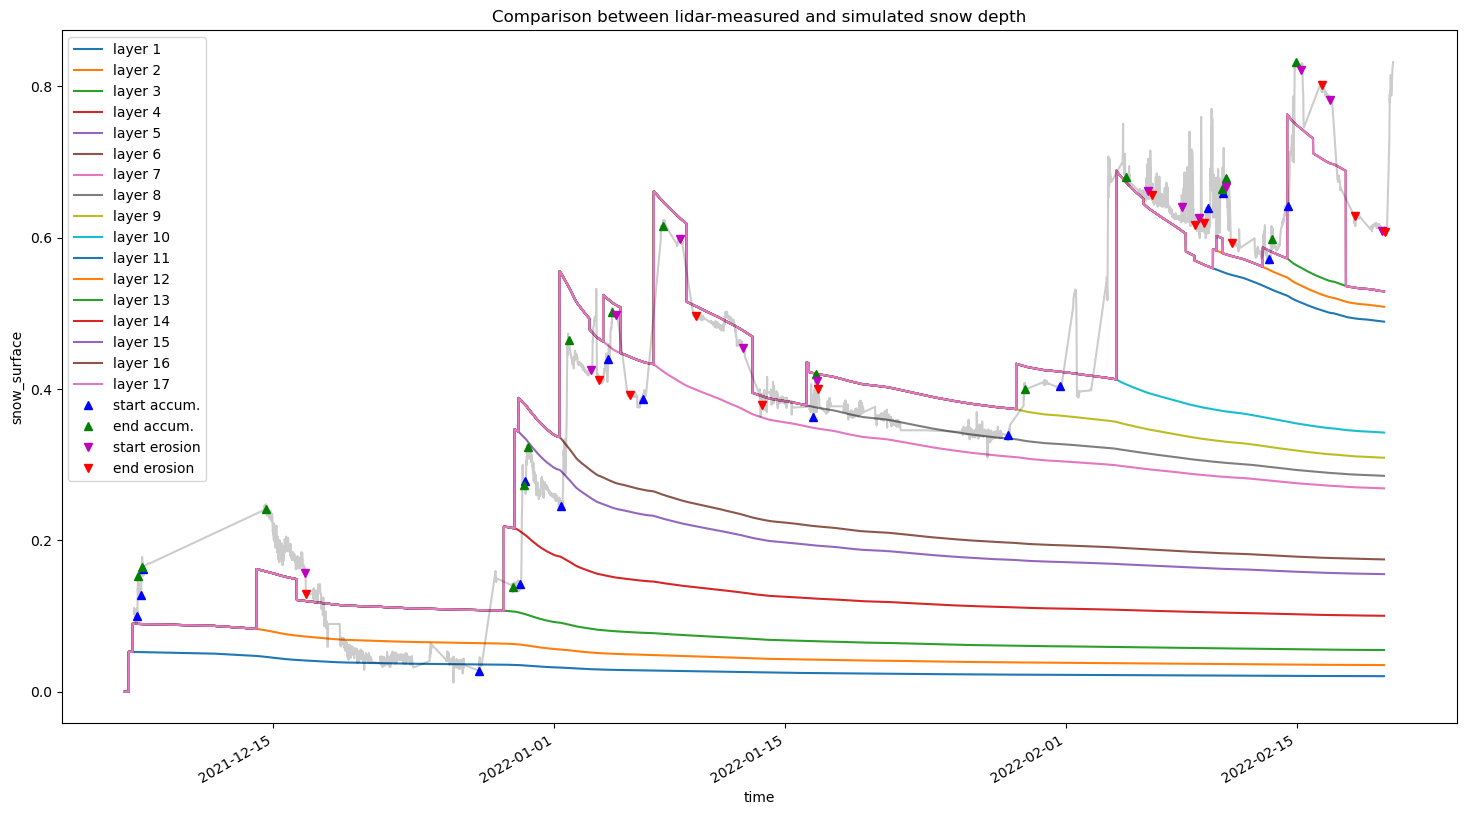

In [14]:
plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution, nb_layers_to_plot, data_start_date, dt, nb_iterations,
                      start_accumulation, end_accumulation, start_erosion, end_erosion, my_figsize=figure_size,
                      save_file=save_file_to_png, my_file_name=file_name, my_title=title)

# TODO add parameters as subtitle automatically

In [15]:
# data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=start_accumulation[0])

In [16]:
# Note on the above figure: if erosion and accumulation are quasi-simultaneous, they will not be taken into account (the timestamp is passed, so we add a layer, 
# and then delete it because the other timestamp is passed). If the erosion is smalle rthan the accumulation, the same thing happens but instead of deleting the layer we just added,
# we reduce it and thus create a small layer.

# The code does what we want it to correctly, even though looking at the curves may be confusing because we cannot see the discretization directly.


## Other plots, less interesting for now

In [17]:
# Converting met_time to compatible units with temperature evolution plot

met_time_compatible = []

for time_index in range(len(met_time)):
    met_time_compatible.append(met_time[time_index]/100)

Text(0, 0.5, 'Temperature')

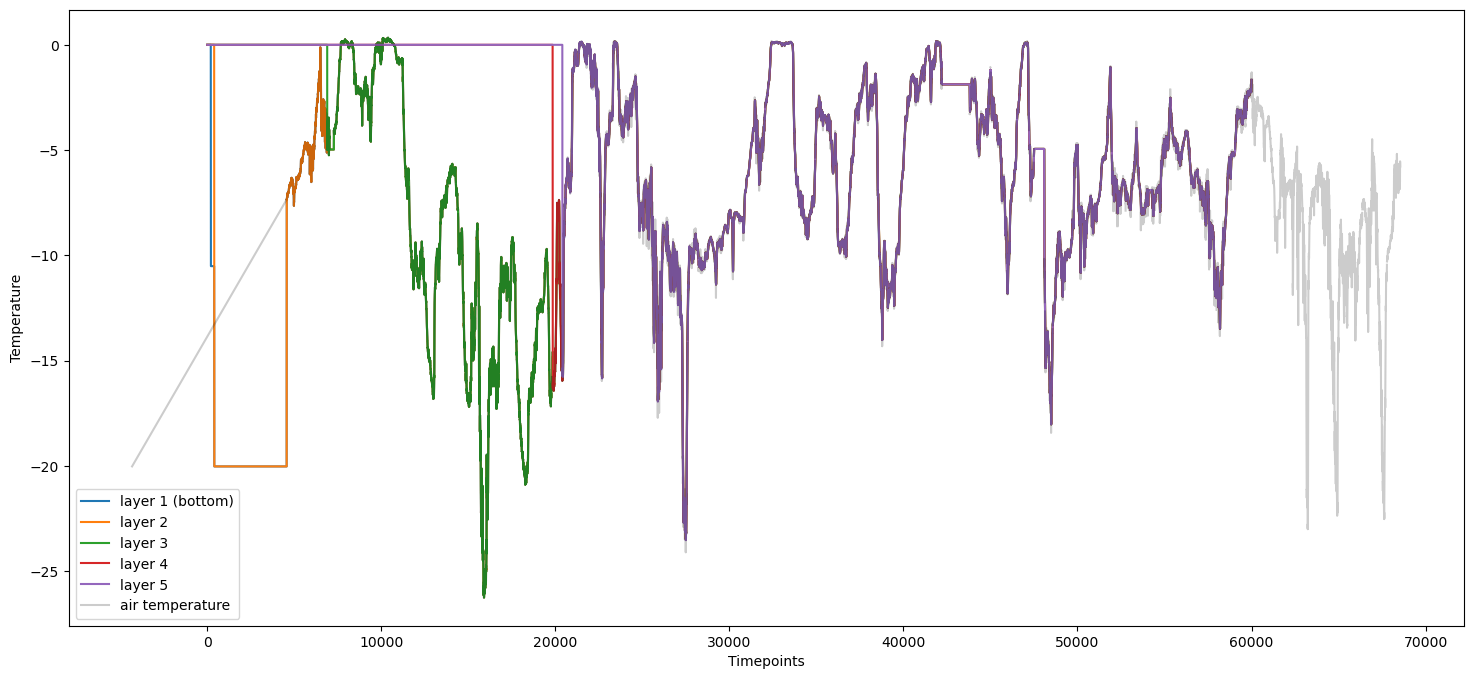

In [22]:
# Temperature

layer1 = [temperature_evolution[i][0] for i in range(60000)]#(len(temperature_evolution))]
layer2 = [temperature_evolution[i][1] for i in range(60000)]#(len(temperature_evolution))]
layer3 = [temperature_evolution[i][2] for i in range(60000)]#(len(temperature_evolution))]
layer4 = [temperature_evolution[i][3] for i in range(60000)]#(len(temperature_evolution))]
layer5 = [temperature_evolution[i][4] for i in range(60000)]#(len(temperature_evolution))]

plt.figure(figsize=(18, 8))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')

plt.plot(met_time_compatible, met_temp, c='k', alpha=0.2, label='air temperature')

plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Temperature')

In [19]:
# TODO pas de temps sont trop grands pour temperature ? nope, dt has no influence it seems

Text(0, 0.5, 'Density')

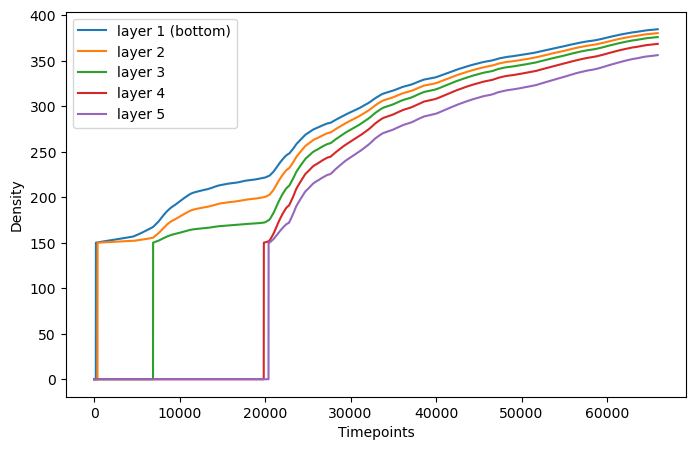

In [20]:
# Density

layer1 = [ro_layer_evolution[i][0] for i in range(len(ro_layer_evolution))]
layer2 = [ro_layer_evolution[i][1] for i in range(len(ro_layer_evolution))]
layer3 = [ro_layer_evolution[i][2] for i in range(len(ro_layer_evolution))]
layer4 = [ro_layer_evolution[i][3] for i in range(len(ro_layer_evolution))]
layer5 = [ro_layer_evolution[i][4] for i in range(len(ro_layer_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1 (bottom)')
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(layer4, label='layer 4')
plt.plot(layer5, label='layer 5')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Density')

[Back to top section](#top)